# Time series analysis - Example code 19: Recursive least squares

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.linalg import hankel

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')

from tsa_lth.analysis import pzmap

## Simulate an AR process

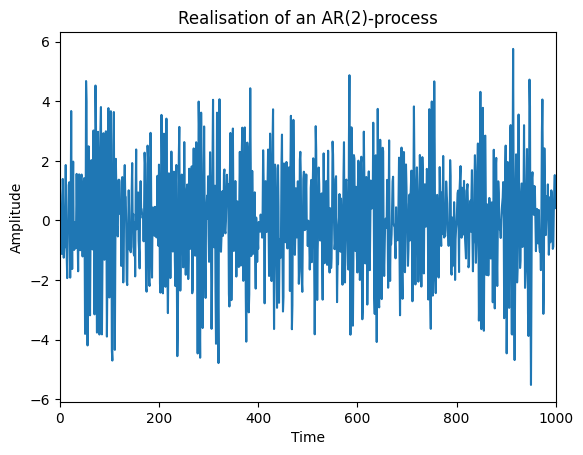

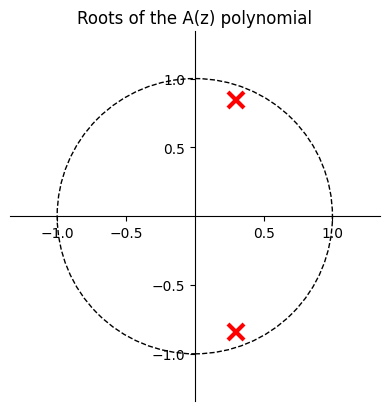

In [2]:
np.random.seed(1)                               # Set the seed (just done for the lecture!)
extraN = 100
N = 1000
A = np.array([1, -0.6, 0.8])
# A = np.array([1, -0.6, 0.8, 0.2])            # Try adding a third param.
e = np.random.randn(N + extraN)
y = lfilter([1], A, e)
y = y[extraN:]
p = len(A) - 1

# Plot realisation.
plt.figure()
plt.plot(y)
plt.title(f'Realisation of an AR({p})-process')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.xlim([0, N])
plt.show()

plt.figure()
pzmap([1], A, ax=plt.gca(), show=False)
plt.title('Roots of the A(z) polynomial')
plt.show()

## Estimate the parameters using LS (see example 5.6)

In [3]:
X = hankel(y[p-1::-1], y[0:N-p+1]).T
theta = -np.linalg.inv(X.T @ X) @ X.T @ y[p-1:N]
stdThLS = 2 * np.std(e) * np.sqrt(np.diag(np.linalg.inv(X.T @ X)))

print('Estimating the AR coefficients.')
print(f'  True coefficients: {A[1]:.2f} and {A[2]:.2f}.')
print(f'  LS estimate:       {theta[1]:.2f} +/- {2*stdThLS[1]:.2f}.')
print(f'  LS estimate:        {theta[0]:.2f} +/- {2*stdThLS[0]:.2f}.')

Estimating the AR coefficients.
  True coefficients: -0.60 and 0.80.
  LS estimate:       -0.60 +/- 0.08.
  LS estimate:        0.80 +/- 0.08.


## Form the RLS estimate (see section 8.3)

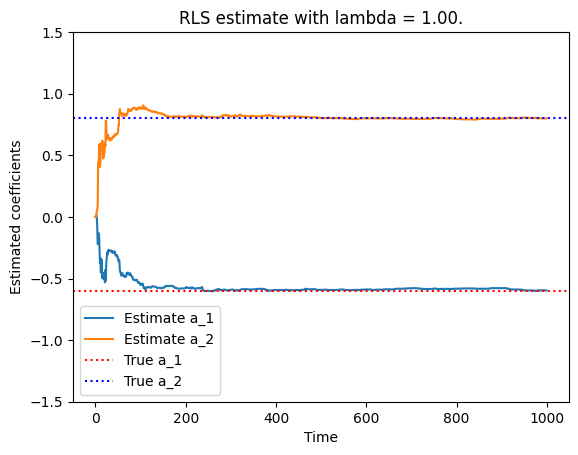

Using a forgetting factor lambda = 1.000.
  RLS estimate:      -0.60 +/- 0.08.
  RLS estimate:       0.80 +/- 0.08.


In [4]:
lambda_ = 1                                     # This is the forgetting factor. Try, e.g., 0.95-0.999.
Pt1 = np.eye(p)                                 # Initial value of P_{t-1}.
th = np.zeros((p, N))                           # Initial values of \theta_t.

for t in range(p, N):
    xt = -y[t-1:t-1-p:-1] if t-1-p >= 0 else -y[t-1::-1]  # Form regressor (see also example 5.6).
    Pt1x = Pt1 @ xt                             # Pre-compute to save calculations.
    nom = lambda_ + xt.T @ Pt1x

    Kt = Pt1x / nom
    Pt1 = (Pt1 - np.outer(Pt1x, Pt1x) / nom) / lambda_

    th[:, t] = th[:, t-1] + Kt * (y[t] - xt.T @ th[:, t-1])

plt.figure()
plt.plot(th.T)
plt.axhline(y=A[1], color='red', linestyle=':', label='True a_1')
plt.axhline(y=A[2], color='blue', linestyle=':', label='True a_2')
plt.legend(['Estimate a_1', 'Estimate a_2', 'True a_1', 'True a_2'], loc='best')
plt.xlabel('Time')
plt.ylabel('Estimated coefficients')
plt.ylim([-1.5, 1.5])
plt.title(f'RLS estimate with lambda = {lambda_:.2f}.')
plt.show()

stdThRLS = 2 * np.sqrt(np.diag(Pt1))
print(f'Using a forgetting factor lambda = {lambda_:.3f}.')
print(f'  RLS estimate:      {th[0, N-1]:.2f} +/- {2*stdThRLS[0]:.2f}.')
print(f'  RLS estimate:       {th[1, N-1]:.2f} +/- {2*stdThRLS[1]:.2f}.')